# Import Related Package

In [8]:
# Config GPU Resource
GPU_NUMBER = "0" #2

import os
os.environ['CUDA_VISIBLE_DEVICES']=f"{GPU_NUMBER}"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# packages
from tensorflow import keras
import tensorflow.keras.layers 
import tensorflow.keras.backend
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import *
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import *
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from collections import *


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct
import pathlib
import os
import glob
import itertools
import seaborn as sns
import shutil
import joblib


import json

print("Devices", tf.config.list_physical_devices(device_type=None))

Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Global Enviroment Variable

In [9]:
# -------------------- preprocess --------------------
# MODEL_DESCRIPTION = "1_8_pkts_14_features_archive"
MODEL_DESCRIPTION = "1_8_pkts_14_features_archive_withoutIAT"
MODEL_NAME = "sae"
SCRIPT_FILE_NAME = "2_SAE.ipynb" # You can't use libray directly to get ipynb name because it runs at jupyter.
CACHE_DIR_NAME = "sae_8_pkts_14_features_without_aug" 

classesJsonPath = "./classes.json"

MALWARE_TYPE = {}
with open(classesJsonPath) as jsonFile:
    MALWARE_TYPE = json.load(jsonFile)


# ---------------- dependent/nonchange variables ------------------------
NUMBER_OF_PKTS_PER_SESSION = CACHE_DIR_NAME.split("_")[1]
NUMBER_OF_FEATURES = CACHE_DIR_NAME.split("_")[3]
SAVE_DIRECTORY = f"model/{MODEL_NAME}/{MODEL_DESCRIPTION}"
CACHE_DIR = f"csv_without_aug/{CACHE_DIR_NAME}"
pathlib.Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)
CACHE_FILE_NAME = ["x_train.csv", "x_test.csv", "y_train.csv", "y_test.csv"]



# -------------------- Training Model --------------------
TRAINING_HISTORY_FILE_NAME = "training_log.csv"
LOSS = keras.losses.mean_squared_error 
OPTIMIZER = keras.optimizers.Adam()
EMBEDDING_LAYER_OUTPUT_SIZE = 16 # 64
EPOCHS_SIZE = 30 # 25
BATCH_SIZE = 32 # 32


# Read Cache file

In [10]:
# -------------------------- check validation set is existed ------------------------------
print("---- check if the validation set is existed ----")
hasValidationSet = False
if not (os.path.isfile(f"{CACHE_DIR}/{CACHE_FILE_NAME[2]}") or os.path.isfile(f"{CACHE_DIR}/{CACHE_FILE_NAME[5]}")):
    hasValidationSet = False
    print("no validation set in this cache directory!!")
print("==== check if the validation set are existed end ====")
# ========================== check validation set is existed ==============================

# -------------------------- Read Data ------------------------------
# xTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[0]}").to_numpy()    
# xTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[1]}").to_numpy()    

xTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[0]}")
xTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[1]}")
columns_to_drop = xTrainRawData.filter(like='windowMean').columns
xTrainRawData_cleaned = xTrainRawData.drop(columns=columns_to_drop)
xTestRawData_cleaned = xTestRawData.drop(columns=columns_to_drop)
xTrainRawData = xTrainRawData_cleaned.to_numpy()
xTestRawData = xTestRawData_cleaned.to_numpy()

yTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[2]}").replace(MALWARE_TYPE).to_numpy()    
yTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[3]}").replace(MALWARE_TYPE).to_numpy()  
     


print(xTrainRawData.shape)
print(xTestRawData.shape)

print(yTrainRawData.shape)
print(yTestRawData.shape)

print("---- read end ----")
# ========================== Read Data =============================

# -------------------------- Normalized Data ------------------------------
print("---- normalized data ----")
yTrain = np_utils.to_categorical(yTrainRawData, len(MALWARE_TYPE))
yTest = np_utils.to_categorical(yTestRawData, len(MALWARE_TYPE))

# normalized
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrainRawData)
xTest = scaler.transform(xTestRawData)


print(xTrain.shape)
print(xTest.shape)

print(yTrain.shape)
print(yTest.shape)

print("==== normalized end ====")
# ========================== Normalized Data =============================

print("---- save mean & std variables ----")
scalerMeanDF = pd.DataFrame(scaler.mean_)
scalerStdDF = pd.DataFrame(scaler.scale_)
scalerMeanDF.to_csv(f"{SAVE_DIRECTORY}/standardscaler_mean.csv", index=False, header=False)
scalerStdDF.to_csv(f"{SAVE_DIRECTORY}/standardscaler_std.csv", index=False, header=False)
joblib.dump(scaler, f"{SAVE_DIRECTORY}/standard_scaler_param.bin", compress=True)
print("==== save mean & std variables ====")

print("==== preprocess success ====")

---- check if the validation set is existed ----
==== check if the validation set are existed end ====
(40435, 13)
(10109, 13)
(40435, 1)
(10109, 1)
---- read end ----
---- normalized data ----
(40435, 13)
(10109, 13)
(40435, 22)
(10109, 22)
==== normalized end ====
---- save mean & std variables ----
==== save mean & std variables ====
==== preprocess success ====


# Sparse Auto-encoder (SAE)

In [11]:
saeInput = keras.Input(shape=(xTrain.shape[1]), name="sae_input")

# encoder = Dense(64)(input_session)

encoder = Dense(EMBEDDING_LAYER_OUTPUT_SIZE,
                activity_regularizer=regularizers.l1(10e-5), name="sae_encoder_1")(saeInput) # origin: sae_code_layer
encoder = LeakyReLU(name='sae_embedding_layer')(encoder)

# decoder = Dense(64)(encoder)

decoder = Dense(xTrain.shape[1], name="sae_decoder_1")(encoder)
saeRestruction = LeakyReLU(name="sae_decoder_1_activation")(decoder)

sae = keras.Model(saeInput, saeRestruction)
sae.compile(optimizer=OPTIMIZER, loss=LOSS)
sae.summary()
np_utils.plot_model(sae, to_file=f'{SAVE_DIRECTORY}/{MODEL_NAME}.png', show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sae_input (InputLayer)      [(None, 13)]              0         
                                                                 
 sae_encoder_1 (Dense)       (None, 16)                224       
                                                                 
 sae_embedding_layer (Leaky  (None, 16)                0         
 ReLU)                                                           
                                                                 
 sae_decoder_1 (Dense)       (None, 13)                221       
                                                                 
 sae_decoder_1_activation (  (None, 13)                0         
 LeakyReLU)                                                      
                                                                 
Total params: 445 (1.74 KB)
Trainable params: 445 (1.74 KB)

## Training Stage

In [12]:
historyLogger = tf.keras.callbacks.CSVLogger(f"{SAVE_DIRECTORY}/{TRAINING_HISTORY_FILE_NAME}", separator=",")

# https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/keras-%E7%82%BA%E4%BD%95-val-acc%E6%B0%B8%E9%81%A0-0-0000e-00-2879e20f1fca
# https://github.com/tensorflow/tensorflow/issues/39370

history = sae.fit(xTrain, xTrain,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS_SIZE,
                    callbacks=[historyLogger],  
                    verbose=1)
    
sae.save(f"{SAVE_DIRECTORY}/{MODEL_NAME}.h5")
shutil.copy(os.getcwd() + "/" + SCRIPT_FILE_NAME , f"{SAVE_DIRECTORY}/{SCRIPT_FILE_NAME}") # copy source code

Epoch 1/30
1264/1264 [==============================] - 1s 611us/step - loss: 0.2332
Epoch 2/30
1264/1264 [==============================] - 1s 619us/step - loss: 0.0271
Epoch 3/30
1264/1264 [==============================] - 1s 599us/step - loss: 0.0129
Epoch 4/30
1264/1264 [==============================] - 1s 639us/step - loss: 0.0076
Epoch 5/30
1264/1264 [==============================] - 1s 601us/step - loss: 0.0052
Epoch 6/30
1264/1264 [==============================] - 1s 587us/step - loss: 0.0041
Epoch 7/30
1264/1264 [==============================] - 1s 626us/step - loss: 0.0033
Epoch 8/30
1264/1264 [==============================] - 1s 556us/step - loss: 0.0028
Epoch 9/30
1264/1264 [==============================] - 1s 602us/step - loss: 0.0026
Epoch 10/30
1264/1264 [==============================] - 1s 557us/step - loss: 0.0023
Epoch 11/30
1264/1264 [==============================] - 1s 592us/step - loss: 0.0021
Epoch 12/30
1264/1264 [==============================] - 1s 616

c:\Users\CIA_Kenny\AppData\Local\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'model/sae/1_8_pkts_14_features_archive_withoutIAT/2_SAE.ipynb'

# Estminate Performance

In [13]:
def plot_training_history(csvPath, savedDirPath, hasValidationSet):
    history = pd.read_csv(csvPath, sep=',', engine='python')
    plt.plot(history['loss'], label="loss")
    if hasValidationSet:
        plt.plot(history['val_loss'], label="val_loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(f"{savedDirPath}/train_loss.png")
    plt.show()

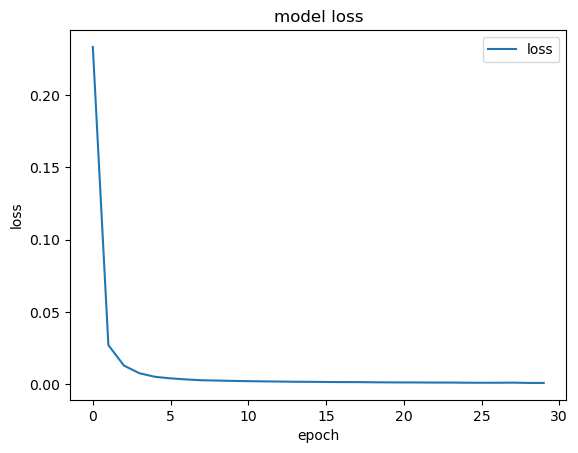

In [14]:
plot_training_history(f"{SAVE_DIRECTORY}/{TRAINING_HISTORY_FILE_NAME}", f"{SAVE_DIRECTORY}", hasValidationSet)